# Data Project - The Resilience of the Danish Labour Market
### Introduction to Programming and Numerical Analysis

**University of Copenhagen, spring semester 2021**

Exam hand-in by group: *4-8-15-16-23-42*

This project investigates how the gross unemployment rates of different Danish industries have been affected by the Covid-19 crisis and its resulting economic drawdown. Moreover, we compare the resilience to financial turbulence of these groups during the COVID-19 crisis the Great Financial Crisis (GFC). Specifically we compare data from three Danish unemployment insurance funds (3F, Akademikernes a-kasse and Børne- og Ungdomspædagoger (BUPL-A)) using data from the Statistics Denmark API. Then, we combine the unemployment data with Covid-19 hospitalization numbers. The analysis concludes that, in our sample, the workers belonging to 3F have been affected mostly relative to the other chosen groups. This could be due to the higher degree of labor demand elasticity in the sectors employing workers of lower education levels. This conclusion is corroborated by investigating the same groups during the GFC, where we also see find large degree of layoffs during the first months of the crisis compared to the groups with longer educations.

We start the analysis by importing the necessary modules:

In [20]:
import numpy as np
import pandas as pd
import pandas_datareader
import pandas_datareader.data as web
import datetime as dt

import pydst # import of the Statistics Denmark API wrapper
dst = pydst.Dst(lang='en') # changing the language to English for API lookups

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Part 1: Unemployment During the COVID-19 Crisis

The following code blocks import data that describes the development in the unemployment rate of different industries. In order to find the relevant data, we investigate the available contents from the Statistics Denmark API:

In [2]:
dst.get_subjects() # obtaining all top level categories from DST

,id,desc,active,hasSubjects
0,02,Population and elections,True,True
1,04,"Labour, income and wealth",True,True
2,06,Prices and consumption,True,True
3,05,Living conditions,True,True
4,14,National accounts and government finances,True,True
5,03,Education and knowledge,True,True
6,11,Business sectors,True,True
7,07,Business sector in general,True,True
8,16,Money and credit market,True,True
9,13,External economy,True,True


We see that ID = 04 seems relevant for our analysis. Further investigation will reveal that we need the AUF02 table. Now, we inspect that table to see what variables it contains:

In [14]:
tables = dst.get_tables()
tables.loc[tables['id'] == 'AUF02'] # printing information about the AUF02 table 

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
276,AUF02,Unemployed persons,number,2021-04-29 08:00:00,2007M01,2020M09,True,"[region, type of benefits, unemployment insura..."


We need the region, and other relevant variables. We need to find out how to sort the data import. To this end, we need the variable ID's for the variables we will base the sort on.

In [15]:
indk_vars = dst.get_variables(table_id='AUF02')

# for loop which prints all ID's and explanatory names
for id in ['AKASSE','KØN']: 
    print(id)
    values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

AKASSE
 id = TOT, text = Total
 id = 48, text = Akademikernes (fra 1. juli 2013 inkl. ingeniører)
 id = 46, text = Byggefagenes a-kasse (fra 1. januar 2021 inkl.  El-faget)
 id = 05, text = Børne- og Ungdomspædagoger (BUPL-A)
 id = 06, text = Din Sundhedsfaglige A-kasse (DSA)
 id = 40, text = Det Faglige Hus A-kasse
 id = 07, text = El-faget (- dec. 2020)
 id = 44, text = Fag og Arbejde (FOA)
 id = 43, text = Faglig Fælles a-kasse (3F)
 id = 11, text = A-kassen Frie (fra 1. januar 2020 inkl. DANA)
 id = 12, text = Funktionærer og Servicefag ( - dec. 2016)
 id = 13, text = Funktionærer og Tjenestemænd (FTF-A)
 id = 27, text = Fødevareforbundet (NNF)
 id = 15, text = Handels- og Kontorfunktionærer (HK)
 id = 41, text = Journalistik, Kommunikation og Sprog
 id = 19, text = Kristelig a-kasse
 id = 21, text = Ledere
 id = 22, text = Lærere (DLF-A)
 id = 23, text = Magistre (MA)
 id = 26, text = Metalarbejdere
 id = 49, text = Min akasse (jan. 2017 - inkl. Funktionærer og Servicefag)
 id = 3

We choose data from three different unemployment insurance funds: 3F, Akademikernes a-kasse and Børne- og Ungdomspædagoger (BUPL-A). We choose these three funds as the members are employed in different industries with different labor demand and supply dynamics.

As the first case of Covid-19 was discovered in Denmark in March 2020, we choose to start the data series in January 2020. The last data point in the table AUF02 is August 2020.

In [16]:
AUF02 = dst.get_data(table_id = 'AUF02', variables={'OMRÅDE':['000'], 'AKASSE':['48','43','05'], 'KØN':['TOT'], 'TID':['2020M01', '2020M02', '2020M03', '2020M04', '2020M05', '2020M06', '2020M07', '2020M08']})
AUF02 = AUF02.loc[AUF02['TID'] != '2007M01'] # define the API lookup

AUF02_pivot = AUF02.pivot(index='TID', columns='AKASSE', values='INDHOLD') # create a pivot table such that all unemployment funds get their own column

AUF02_pivot.reset_index(level=0, inplace=True)
AUF02_pivot["TID"].replace({"2020M01": "January, 2020", "2020M02": "February, 2020", "2020M03": "March, 2020", "2020M04": "April, 2020", "2020M05": "May, 2020", "2020M06": "June, 2020", "2020M07": "July, 2020", "2020M08": "August, 2020"}, inplace=True)

AUF02_pivot.columns.name = AUF02_pivot.index.name
AUF02_pivot.index.name = None

AUF02_pivot.head(8) # print entire table (only 8 rows!)

,TID,Akademikernes (fra 1. juli 2013 inkl. ingeniører),Børne- og Ungdomspædagoger (BUPL-A),Faglig Fælles a-kasse (3F)
0,"January, 2020",10236,2048,16150
1,"February, 2020",10558,2138,15817
2,"March, 2020",10775,2023,17588
3,"April, 2020",11687,2099,20209
4,"May, 2020",12258,2011,19501
5,"June, 2020",12734,2403,17295
6,"July, 2020",14564,2742,14281
7,"August, 2020",14454,2381,13526


We will now download COVID statistics, also from the DST API, in the table SMIT1. Again we need the variable IDs for the variables we will base the sort on:

In [6]:
SMIT1_vars = dst.get_variables(table_id='SMIT1')
SMIT1_vars
 
for id in ['AKTP']:
    print(id)
    values = SMIT1_vars.loc[SMIT1_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

AKTP
 id = 10, text = Confirmed cases of COVID-19 (total)
 id = 15, text = Recovered from COVID-19 infection (total)(02.04.2020 -)
 id = 17, text = Number of COVID-19 PCR tests (total) (24.03.2021)
 id = 18, text = Number of Covid-19 tests (total) (10.05.2020 -)
 id = 19, text = Number of COVID-19 antigen tests (total) (24.03.2021)
 id = 20, text = Number of persons PCR tested for COVID-19 (total)
 id = 25, text = Deaths with COVID-19 (total)
 id = 30, text = Deaths with COVID-19 per day
 id = 35, text = Persons hospitalised in connection with COVID-19
 id = 40, text = Patients in intensive care units in connection with COVID-19
 id = 45, text = Patients on ventilators in connection with COVID-19
 id = 51, text = Number of persons partly vaccinated (total) (27.12.2021)
 id = 56, text = Number of persons partly vaccinated (total) (27.12.2021)


As a proxy for the prevalence of COVID-19 we use data for the number of hospitalized due to the virus. SMIT1 is calculated on a daily basis, and in order to compare these data with the data from AUF02 we assign the first observation in each month to that month. As the first cases of COVID-19 were discovered in January 2020 the SMIT1 data from DST starts in this month. Therefore, we add two datapoints for January and February - in both month the number of hospitalized were obviously 0.

In [18]:
SMIT1 = dst.get_data(table_id = 'SMIT1', variables={'AKTP':['35'], 'TID':['2020M04D01', '2020M05D01', '2020M06D01', 
                                                                          '2020M07D01', '2020M08D03']})

# create zero value rows for hospitalizations before Covid-19 hit Denmark
NewRowsJan = pd.DataFrame({'AKTP':'Indlagte på sygehusene ifm. COVID-19', 'TID':'2020M01', 'INDHOLD':0}, index=[0]) 
NewRowsFeb = pd.DataFrame({'AKTP':'Indlagte på sygehusene ifm. COVID-19', 'TID':'2020M02', 'INDHOLD':0}, index=[0])

SMIT1 = pd.concat([NewRowsJan, NewRowsFeb, SMIT1]).reset_index(drop = True)

SMIT1["TID"].replace({"2020M01": "January, 2020", "2020M02": "February, 2020", "2020M03D21": "March, 2020", 
                      "2020M04D01": "April, 2020", "2020M05D01": "May, 2020", "2020M06D01": "June, 2020", 
                      "2020M07D01": "July, 2020", "2020M08D03": "August, 2020"}, inplace=True)

SMIT1.set_index("TID")

SMIT1

,AKTP,TID,INDHOLD
0,Indlagte på sygehusene ifm. COVID-19,"January, 2020",0
1,Indlagte på sygehusene ifm. COVID-19,"February, 2020",0
2,Persons hospitalised in connection with COVID-19,"March, 2020",206
3,Persons hospitalised in connection with COVID-19,"April, 2020",535
4,Persons hospitalised in connection with COVID-19,"May, 2020",229
5,Persons hospitalised in connection with COVID-19,"June, 2020",88
6,Persons hospitalised in connection with COVID-19,"July, 2020",29
7,Persons hospitalised in connection with COVID-19,"August, 2020",24


We now delete the column 'AKTP' and change the name of the column "Indhold". Next, we merge the two tables.

In [8]:
del SMIT1["AKTP"]

# rename the column
SMIT1=SMIT1.rename(columns={"INDHOLD":"Hospitalized with COVID-19"})

# now, join AUF02 and SMIT1 on the TID column
AUF02_SMIT1 = pd.merge(AUF02_pivot, SMIT1, on = "TID")
AUF02_SMIT1.head(10)

,TID,Akademikernes (fra 1. juli 2013 inkl. ingeniører),Børne- og Ungdomspædagoger (BUPL-A),Faglig Fælles a-kasse (3F),Hospitalized with COVID-19
0,"January, 2020",10236,2048,16150,0
1,"February, 2020",10558,2138,15817,0
2,"March, 2020",10775,2023,17588,206
3,"April, 2020",11687,2099,20209,535
4,"May, 2020",12258,2011,19501,229
5,"June, 2020",12734,2403,17295,88
6,"July, 2020",14564,2742,14281,29
7,"August, 2020",14454,2381,13526,24


Now, to make the data on the three unemployment funds comparable, we index the data, such that January 2020 = 100. 

In [9]:
for column in ['Faglig Fælles a-kasse (3F)', 'Børne- og Ungdomspædagoger (BUPL-A)', 'Akademikernes (fra 1. juli 2013 inkl. ingeniører)']:
        AUF02_SMIT1[column] = AUF02_SMIT1[column].div(AUF02_SMIT1[column].iloc[0])*100
        
AUF02_SMIT1 = AUF02_SMIT1.rename(columns = {"TID":"Month","Akademikernes (fra 1. juli 2013 inkl. ingeniører)": "Akademikernes A-kasse"})
        
AUF02_SMIT1.head(10)

,Month,Akademikernes A-kasse,Børne- og Ungdomspædagoger (BUPL-A),Faglig Fælles a-kasse (3F),Hospitalized with COVID-19
0,"January, 2020",100.000000,100.000000,100.000000,0
1,"February, 2020",103.145760,104.394531,97.938080,0
2,"March, 2020",105.265729,98.779297,108.904025,206
3,"April, 2020",114.175459,102.490234,125.133127,535
4,"May, 2020",119.753810,98.193359,120.749226,229
5,"June, 2020",124.404064,117.333984,107.089783,88
6,"July, 2020",142.282141,133.886719,88.427245,29
7,"August, 2020",141.207503,116.259766,83.752322,24


Now, we plot the data using the matplotlib package.

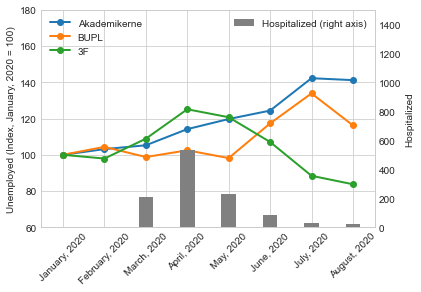

In [10]:
# Using matplotlib to visualize the data obtained, starting out with making a line chart
ax = AUF02_SMIT1.iloc[:, [1,2,3]].plot(use_index=True, linestyle='-', marker='o', linewidth=2.0)

# Rotating the ticks on the x-axis 45 degrees
plt.xticks(rotation=45)
plt.legend(['Akademikerne', 'BUPL', '3F'], loc = 2)

# Adding a secondary y-axis for the same x-axis
ax2 = ax.twinx()

# Combining the first chart with a bar chart
ax2.bar(AUF02_SMIT1.iloc[:, 0], AUF02_SMIT1.iloc[:, 4].values, data=AUF02_SMIT1, color='gray',width=0.35,label='NE',zorder=0)
ax2.grid(None)

# Setting the labels for the two y-axis
ax.set_ylabel('Unemployed (Index, January, 2020 = 100)')
ax2.set_ylabel('Hospitalized')

# Modifying the two y-axis to give a clearer visual of correlation.
ax.set_ylim([60, 180])
ax2.set_ylim([0, 1500])

plt.legend(['Hospitalized (right axis)'], loc = 1)
plt.show()

The main insight from the figure above, and the analysis in general, is that the workers belonging to 3F (mostly industrial workers) were the ones being hit mostly in the beginning of the crisis, implying a low degree of labour hoarding for this group. Conversely, the workers belonging to Akademikernes A-kasse (university graduates), experienced a more gradual increase in gross unemployment, suggesting a high degree of labour hoarding. Moreover, the industrial workers experienced a boom in employment during the late spring and early summer of 2020, also suggesting that there is a high degree of elasticity in labour demand for this group.

## Part 2: Unemployment During the GFC

Now, we repeat the analysis, where we instead of COVID-19 hospitalizations use stock prices as indicators of the economic and financial distress. We start by importing stock prices and continue with loading unemployment numbers for the period of August 1st 2008 through August 1st 2009.

In [11]:
start = dt.datetime(2008,8,1)
end = dt.datetime(2009,8,1)

# Specifying the tickers we want prices for (the Dow Jones Industrial Average constituents, incl. the index itself)
tickers = ['^OMXN40','NOVO-B.CO', 'CARL-B.CO', 'FLS.CO']

# Specify which API we want to use 
data_source = 'yahoo'

# Get adjusted closing prices (adjusted for dividends etc.) from the tickers of Dow Jones through the Yahoo! Finance API 
prices = web.DataReader(tickers, data_source, start, end)['Adj Close']

for column in ['^OMXN40','NOVO-B.CO', 'CARL-B.CO', 'FLS.CO']:
        prices[column] = prices[column].div(prices[column].iloc[0])*100

In [22]:
# now, get unemployment data for the same period
AUF02_GFC = dst.get_data(table_id = 'AUF02', variables={'OMRÅDE':['000'], 'AKASSE':['16','43','05'], 'KØN':['TOT'], 
                                                        'TID':['2008M08', '2008M09', '2008M10', '2008M11', '2008M12', 
                                                               '2009M01', '2009M02', '2009M03','2009M04','2009M05',
                                                               '2009M06','2009M07','2009M08']})

AUF02_GFC = AUF02_GFC.loc[AUF02_GFC['TID'] != '2007M01'] # define the API lookup

AUF02_GFC_pivot = AUF02_GFC.pivot(index='TID', columns='AKASSE', values='INDHOLD') # create a pivot table such that all unemployment funds get their own column

AUF02_GFC_pivot.columns.name = AUF02_GFC_pivot.index.name
AUF02_GFC_pivot.index.name = None

for column in ['Faglig Fælles a-kasse (3F)', 'Børne- og Ungdomspædagoger (BUPL-A)', 'Ingeniører (IAK) (- juni 2013)']:
        AUF02_GFC_pivot[column] = AUF02_GFC_pivot[column].div(AUF02_GFC_pivot[column].iloc[0])*100

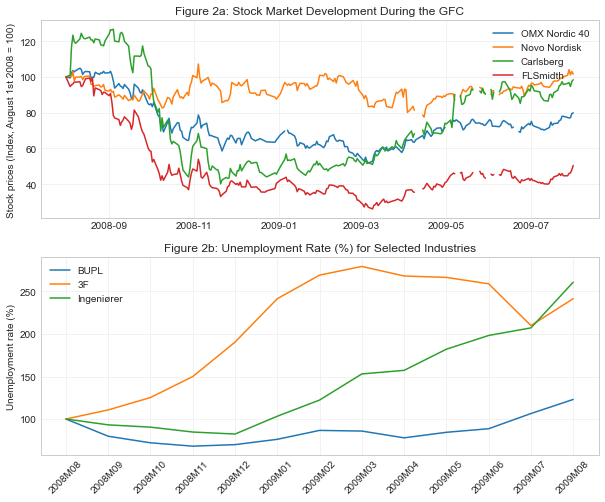

In [24]:
# here we plot the two figures
fig = plt.figure(figsize=(10,8))
plt.tight_layout()
plt.subplot(2,1,1)
plt.plot(prices)
plt.legend(['OMX Nordic 40','Novo Nordisk', 'Carlsberg', 'FLSmidth'], loc = 1)
plt.xticks(rotation=0)
plt.title("Figure 2a: Stock Market Development During the GFC")
plt.grid(alpha=0.3)
plt.ylabel("Stock prices (Index, August 1st 2008 = 100)")

plt.subplot(2,1,2)
plt.plot(AUF02_GFC_pivot)
plt.legend(['BUPL','3F', 'Ingeniører'], loc = 2)
plt.xticks(rotation=45)
plt.title("Figure 2b: Unemployment Rate (%) for Selected Industries")
plt.grid(alpha=0.3)
plt.ylabel("Unemployment rate (%)")
plt.show()

## Conclusion

As concluding remarks, we note that again the part of the workforce with lower education levels exhibit a much larger and quicker reaction to financial distress in the shape of employee layoffs. Not surprisingly, the cyclical part of the economy (e.g. the heavy industry manufacturer FLSmidth) employs people that are easier to hire/fire during booms/busts, which is indeed seen in the data above. The unemployment rate of the engineers is more resilient at first, but picks up to the same level as for the industrial workers, which suggest that there is a degree of labour hoarding present for this group. Finally, the public workers in the BUPL association experienced little to no excess unemployment as a result of the GFC, which is a natural consequence of the public labour market structure.